Splitting datasets: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.36s/it]



Dataset split summary:
Agriculture: Train=640, Test=160
Airport: Train=640, Test=160
Beach: Train=640, Test=160
City: Train=640, Test=160
Desert: Train=640, Test=160
Forest: Train=640, Test=160
Grassland: Train=640, Test=160
Highway: Train=640, Test=160
Lake: Train=640, Test=160
Mountain: Train=640, Test=160
Parking: Train=640, Test=160
Port: Train=640, Test=160
Railway: Train=640, Test=160
Residential: Train=640, Test=160
River: Train=640, Test=160

Starting training...


Epoch 1/10, Loss: 1.1391, Acc: 0.7367


Epoch 2/10, Loss: 0.5868, Acc: 0.8416


Epoch 3/10, Loss: 0.4749, Acc: 0.8595


Epoch 4/10, Loss: 0.4395, Acc: 0.8657


Epoch 5/10, Loss: 0.4217, Acc: 0.8669


Epoch 6/10, Loss: 0.3969, Acc: 0.8745


Epoch 7/10, Loss: 0.3863, Acc: 0.8794


Epoch 8/10, Loss: 0.3727, Acc: 0.8802


Epoch 9/10, Loss: 0.3740, Acc: 0.8824


Epoch 10/10, Loss: 0.3574, Acc: 0.8836



Model Evaluation Metrics:
Precision: 0.8973
Recall: 0.8925
F1 Score: 0.8929

Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.910     0.944     0.926       160
     Airport      0.902     0.863     0.882       160
       Beach      0.971     0.844     0.903       160
        City      0.897     0.869     0.883       160
      Desert      0.940     0.881     0.910       160
      Forest      0.948     0.919     0.933       160
   Grassland      0.885     0.912     0.898       160
     Highway      0.732     0.975     0.836       160
        Lake      0.854     0.838     0.845       160
    Mountain      0.874     0.956     0.913       160
     Parking      0.929     0.894     0.911       160
        Port      0.939     0.869     0.903       160
     Railway      0.883     0.800     0.839       160
 Residential      0.922     0.956     0.939       160
       River      0.874     0.869     0.871       160

    accuracy                     

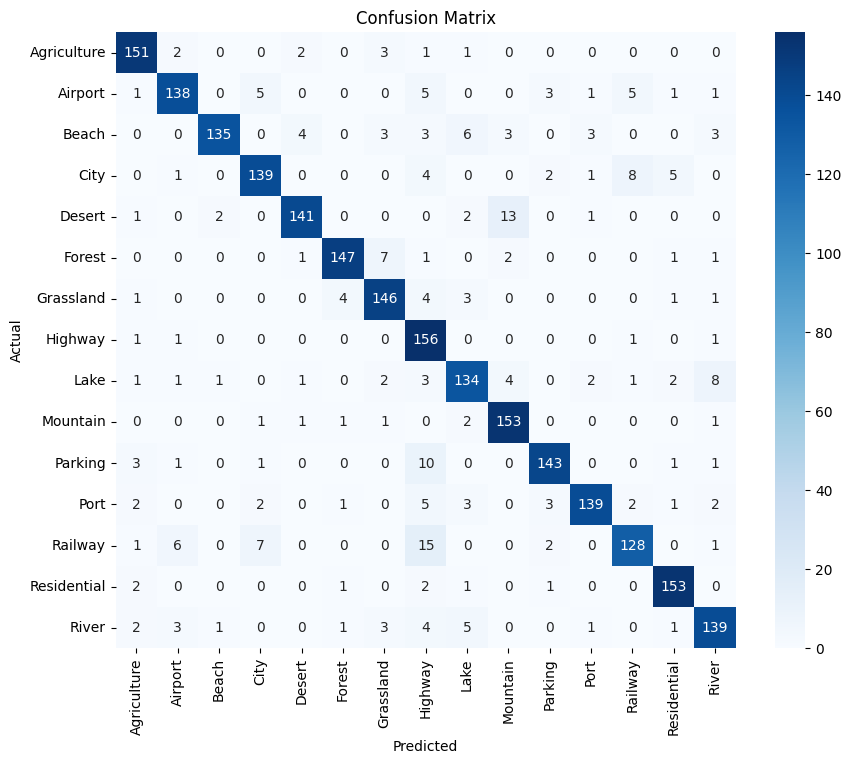


Model saved to landscape_classifier.pth


In [6]:
#EfficientNet-B3
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
config = {
    "data_dir": "Landscapes",
    "selected_classes": [
        "Agriculture", "Airport", "Beach", "City", "Desert",
        "Forest", "Grassland", "Highway", "Lake", "Mountain",
        "Parking", "Port", "Railway", "Residential", "River"
        ],
    "train_dir": "train_data",
    "test_dir": "test_data",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

def prepare_datasets():
    """Create train/test splits with 80% training and 20% test data per class."""
    # Clean existing directories
    for d in [config["train_dir"], config["test_dir"]]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    for cls in tqdm(config["selected_classes"], desc="Splitting datasets"):
        # Create class directories
        os.makedirs(os.path.join(config["train_dir"], cls), exist_ok=True)
        os.makedirs(os.path.join(config["test_dir"], cls), exist_ok=True)

        src_dir = os.path.join(config["data_dir"], cls)
        all_images = [f for f in os.listdir(src_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not all_images:
            raise FileNotFoundError(f"No images found in {src_dir}")

        np.random.shuffle(all_images)
        split_idx = int(0.8 * len(all_images))

        for img in all_images[:split_idx]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["train_dir"], cls, img)
            shutil.copy2(src, dst)

        for img in all_images[split_idx:]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["test_dir"], cls, img)
            shutil.copy2(src, dst)

    print("\nDataset split summary:")
    for cls in config["selected_classes"]:
        train_count = len(os.listdir(os.path.join(config["train_dir"], cls)))
        test_count = len(os.listdir(os.path.join(config["test_dir"], cls)))
        print(f"{cls}: Train={train_count}, Test={test_count}")

def get_dataloaders():
    """Create augmented dataloaders"""
    # train_transform = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.RandomResizedCrop(224),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # ])
    train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(config["train_dir"], transform=train_transform)
    test_dataset = datasets.ImageFolder(config["test_dir"], transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    return train_loader, test_loader, train_dataset.classes

def initialize_model():
    """EfficientNet-B3 """
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[-1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(config["selected_classes"]))
    model = model.to(config["device"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[-1].parameters(), lr=config["learning_rate"])
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n" + "="*50)
    print(f"Model Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("="*50 + "\n")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=3))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

if __name__ == "__main__":
    prepare_datasets()

    train_loader, test_loader, class_names = get_dataloaders()

    model, criterion, optimizer = initialize_model()

    print("\nStarting training...")
    for epoch in range(config["num_epochs"]):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

    evaluate_model(model, test_loader, class_names)

    torch.save(model.state_dict(), "landscape_classifier.pth")
    print("\nModel saved to landscape_classifier.pth")